Andreev spectrum of nanostructure-based junction
syst1: TI system without TRS

# import Kwant

In [41]:
import scipy
scipy.__version__

'1.12.0'

In [31]:
import kwant
print(kwant.version.version)

import matplotlib

import matplotlib.pyplot as plt
plt.style.use('genstyle')

import pandas as pd

import scipy.sparse.linalg as sla

import numpy as np
import kwant
import kwant.continuum
import peierls as peierls

#import adaptive
#import holoviews as hv
#from holoviews import opts
#adaptive.notebook_extension()
#from concurrent.futures import ProcessPoolExecutor
#from operator import itemgetter

import  sympy
from sympy.physics.matrices import msigma, Matrix
from sympy import eye
from sympy.physics.quantum import TensorProduct

from sympy.utilities.exceptions import SymPyDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=SymPyDeprecationWarning)


import scipy.signal
from scipy.stats import multivariate_normal

1.4.3


In [32]:
import matplotlib
print(matplotlib.__version__)

3.3.4


In [33]:
pd.options.display.float_format = "{:,.2f}".format
plt.style.use('genstyle')

# System creation

In [34]:
import numpy as np

# shape of system
def get_shape(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= x <= L and 0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

# shape of leads
def get_shape_lead_0(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

def get_shape_lead_1(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    return shape, np.array([L, 0, 0])

L_x = 100
W_y = 100
H_z = 100

## 3DTI hamiltonian

In [70]:
import kwant.continuum


norbs = 8 # 8 orbitals (2 for particle-hole x 2 for spin up-down x 2 for orbitals A/B)
ham_TI = ("- mu_bulk * kron(sigma_z, sigma_0, sigma_0) + "
          "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
          "{M} * kron(sigma_z, sigma_0, sigma_z) - "
          "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
          "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
          "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
          "m_z * kron(sigma_z, sigma_z, sigma_0) + "
          "S_mag * S_imp(site) * kron(sigma_z, sigma_0, sigma_0)")

ham_TI_lead1 = ("- mu_lead1 * kron(sigma_z, sigma_0, sigma_0) + "
          "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
          "{M} * kron(sigma_z, sigma_0, sigma_z) - "
          "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
          "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
          "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
          "m_z * kron(sigma_z, sigma_z, sigma_0) ")

ham_TI_lead2 = ("- mu_lead2 * kron(sigma_z, sigma_0, sigma_0) + "
          "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
          "{M} * kron(sigma_z, sigma_0, sigma_z) - "
          "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
          "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
          "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
          "m_z * kron(sigma_z, sigma_z, sigma_0) ")


epsilon = "(C_0 - C_perp * (k_x**2 + k_y**2) - C_z * k_z**2)"
M = "(M_0 - M_perp * (k_x**2 + k_y**2) - M_z * k_z**2)"

ham_TI = ham_TI.format(epsilon=epsilon, M=M, C_0="C_0")
ham_discr, coords = kwant.continuum.discretize_symbolic(ham_TI)



SC_complex = ("- re({Delta}) * kron(sigma_y, sigma_y, sigma_0) -"
                  "im({Delta}) * kron(sigma_x, sigma_y, sigma_0)")

SC_L_final = SC_complex.format(Delta="Deltaf_L(y, z)")
SC_R_final = SC_complex.format(Delta="Deltaf_R(y, z)")

ham_TI_lead1 = ham_TI_lead1.format(epsilon=epsilon, M=M, C_0="C_0") #+ SC_L_final
ham_discr_lead1, coords = kwant.continuum.discretize_symbolic(ham_TI_lead1)

ham_TI_lead2 = ham_TI_lead2.format(epsilon=epsilon, M=M, C_0="C_0") #+ SC_R_final
ham_discr_lead2, coords = kwant.continuum.discretize_symbolic(ham_TI_lead2)


#signs = [-1, -1, -1, -1, 1, 1, 1, 1]
#vector_potential='[B_y * (z - H_z), - B_x * (z - H_z), 0]'
#ham_discr = peierls.apply(ham_discr, coords, A=vector_potential, signs=signs)
#ham_discr_lead1 = peierls.apply(ham_discr_lead1, coords, A=vector_potential, signs=signs)
#ham_discr_lead2 = peierls.apply(ham_discr_lead2, coords, A=vector_potential, signs=signs)

In [71]:
a = 10
ti_syst = kwant.continuum.build_discretized(ham_discr, coords, grid=a)
ti_lead_0 = kwant.continuum.build_discretized(ham_discr, coords, grid=a)
ti_lead_1 = kwant.continuum.build_discretized(ham_discr, coords, grid=a)
#ti_lead_0 = kwant.continuum.build_discretized(ham_discr_lead1, coords, grid=a)
#ti_lead_1 = kwant.continuum.build_discretized(ham_discr_lead2, coords, grid=a)

In [72]:
sigma_0 = np.identity(2)
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_y = np.array([[0,-1j], [1j,0]])
conservation_law = -np.kron(sigma_z, np.kron(sigma_0, sigma_0))
particle_hole = np.kron(sigma_x, np.kron(sigma_0, sigma_0))
sigma_TR = 1j*sigma_y
#np.array([[0, -1], [1, 0]])
# i*sigma_y
time_reversal = np.kron(sigma_z, np.kron(sigma_TR, sigma_0))

nleads = 2

syst1 = kwant.Builder()
_ = syst1.fill(ti_syst, *get_shape(L_x, W_y, H_z))

lat = kwant.lattice.cubic(a, norbs=norbs)

lead_0 = kwant.Builder(kwant.TranslationalSymmetry((-a, 0, 0)),
                       conservation_law=conservation_law,
                       particle_hole=particle_hole,
                       time_reversal=time_reversal,
                       chiral=None
                      )
lead_1 = kwant.Builder(kwant.TranslationalSymmetry((a, 0, 0)),
                       conservation_law=conservation_law,
                       particle_hole=particle_hole,
                       time_reversal=time_reversal,
                       chiral=None
                      )

lead_0.fill(ti_lead_0, *get_shape_lead_0(L_x, W_y, H_z))
lead_1.fill(ti_lead_1, *get_shape_lead_1(L_x, W_y, H_z))

syst1.attach_lead(lead_0)
syst1.attach_lead(lead_1)

[]

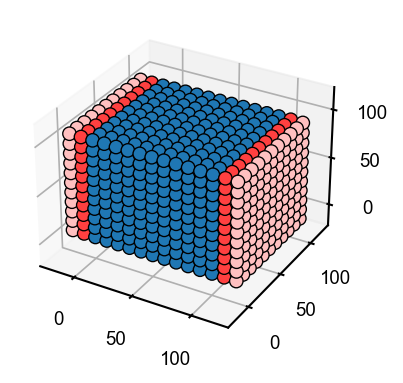

In [73]:
# For kwant version==1.5.0
fig = kwant.plotter.plot(syst1)
#fig.savefig('')

In [74]:
systf1 = syst1.finalized()

In [40]:
systf1.discrete_symmetry().time_reversal

<10648x10648 sparse matrix of type '<class 'numpy.complex128'>'
	with 85184 stored elements in COOrdinate format>

## Define Disorder

### Uncorrelated Disorder

In [41]:
# Define a random number (following gaussian distribution) table for disorder
disorder_3D = np.array([[[kwant.digest.gauss('('+str(ind_x)+ ',' +str(ind_y) + ',' +str(ind_z)+')')
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_x = np.array([[[kwant.digest.gauss(str(ind_x))
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_y = np.array([[[kwant.digest.gauss(str(ind_y))
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_z = np.array([[[kwant.digest.gauss(str(ind_z))
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

def get_S_imp_3D():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_3D[ind_y, ind_x, ind_z]
    return S_imp

def get_S_imp_x():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_x[ind_y, ind_x, ind_z]
    return S_imp

def get_S_imp_y():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_y[ind_y, ind_x, ind_z]
    return S_imp

def get_S_imp_z():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_z[ind_y, ind_x, ind_z]
    return S_imp

### Correlated Disorder

In [42]:
correlation_length = 10# in units of a (lattice constant)
#Smag_imp = 0.05

x, y, z = np.mgrid[-3*correlation_length:3*correlation_length+1:1, -3*correlation_length:3*correlation_length+1:1, -3*correlation_length:3*correlation_length+1:1]
pos = np.stack((x, y, z), axis=3)
rv = multivariate_normal([0, 0, 0], [[correlation_length**2, 0, 0], [0, correlation_length**2, 0], [0, 0, correlation_length**2]])
filter_kernel = rv.pdf(pos)

disorder = np.array([[[kwant.digest.gauss('('+str(ind_x)+ ',' +str(ind_y) + ',' +str(ind_z)+')')
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_fil = scipy.signal.fftconvolve(disorder, filter_kernel, mode='same')
disorder_fil = disorder_fil/np.std(disorder_fil.flatten())

def get_S_imp_correlated():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        #return disorder[ind_y, ind_x, ind_z]
        return disorder_fil[ind_y, ind_x, ind_z]
    return S_imp

## Params dict

In [20]:
Delta = 0.000
params_TI = dict(A_perp=3.0,
                 A_z=3.0,
                 M_0=0.3,
                 M_perp=15.0,
                 M_z=15.0,
                 C_0=0.0,
                 C_perp=0.0,
                 C_z=0.0,
                 m_z=0.0,
                 mu_bulk=0.07,
                 mu_lead1=0.07,
                 mu_lead2=0.07,
                 S_imp = get_S_imp_correlated(),
                 S_mag = 0.00,
                 B_x = 0/(W_y*H_z),
                 B_y = 0/(L_x*H_z),
                 B_z = 0/(L_x*W_y),
                 phi_0=1.0,
                 exp=np.exp,
                 a = 10,
                 re=lambda x: x.real,
                 im=lambda x: x.imag,
                 Deltaf_L = lambda y, z: Delta,
                 Deltaf_R = lambda y, z: Delta*np.exp(1j*0),
                 H_z=H_z
                 )



In [75]:
#params_toy = dict(C_0=0.0,
#                  C_2=3.0,
#                  mu=0.012
#                 )


params_toy = dict(C_0=0.0,
                  C_2=3.0,
                  mu=0.0205,
                  mu_lead1=0.0205,
                  mu_lead2=0.021,
                  S_imp = get_S_imp_x(),
                  S_mag = 0.000
                 )

params_toy_sim = dict(C_0=0.0,
                  C_2=3.0,
                  mu=0.0,
                 )

#params_TI = dict(A_perp=3.0,
#                 A_z=3.0,
#                 M_0=0.3,
#                 M_perp=15.0,
#                 M_z=15.0,
#                 C_0=0.0,
#                 C_perp=0.0,
#                 C_z=0.0,
#                 m_z=0.0,
#                 mu=0.1
#                )

params_TI = dict(A_perp=3.0,
                 A_z=3.0,
                 M_0=0.3,
                 M_perp=15.0,
                 M_z=15.0,
                 C_0=0.0,
                 C_perp=0.0,
                 C_z=0.0,
                 m_z=0.0,
                 mu_bulk=0.042,
                 mu_lead1=0.042,
                 mu_lead2=0.042,
                 S_imp = get_S_imp_correlated(),
                 S_mag = 0.00,
                 B_x = 0.5/(W_y*H_z),
                 B_y = 0,
                 B_z = 0,
                 phi_0=1.0,
                 exp=np.exp,
                 a = 10,
                 H_z=H_z
                 )

params_TI_sim = dict(A_perp=3.0,
                 A_z=3.0,
                 M_0=0.3,
                 M_perp=15.0,
                 M_z=15.0,
                 C_0=0.0,
                 C_perp=0.0,
                 C_z=0.0,
                 m_z=0.0,
                 mu=0
                )

# Andreev spectrum

## Find Bound States (helper functions)

In [82]:
def check_probsymm(matrix, comp_error = 1e-2):
    prob_mat = np.abs(matrix) ** 2
    diff = prob_mat - prob_mat.T
    
    if np.amax(diff) > comp_error:
        #print(diff)
        warnings.warn("Probability matrix is not symmetric")
        print(abs(np.amax(diff)))
        #raise Exception('Probability matrix is not symmetric')
    

def fix_angles(angles):
    while np.any(angles > np.pi):
        angles = angles - 2 * (angles > np.pi) * np.pi
    while np.any(angles < - np.pi):
        angles = angles + 2 * (angles < - np.pi) * np.pi
    return angles


        
def scattering_matrix(syst, p, calibration = None, reorder = True):
    smat = kwant.smatrix(syst, params=p)
    #print(smat.submatrix(0, 0))
    #print(smat.submatrix(1, 1))
    size_L = smat.submatrix((0, 0), (0, 0)).shape[0]
    size_R = smat.submatrix((1, 0), (1, 0)).shape[0]
    mask_e = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
    mask_h = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
    

    mask_e[:size_L, :size_L] = True
    mask_h[size_L:2*size_L, size_L:2*size_L] = True
    mask_e[:size_L, 2*size_L:2*size_L+size_R] = True
    mask_e[2*size_L:2*size_L+size_R,:size_L] = True
    mask_h[size_L:2*size_L, 2*size_L+size_R:2*size_L+2*size_R] = True
    mask_h[2*size_L+size_R:2*size_L+2*size_R,size_L:2*size_L] = True
    mask_e[2*size_L:2*size_L+size_R,2*size_L:2*size_L+size_R] = True
    mask_h[2*size_L+size_R:2*size_L+2*size_R,2*size_L+size_R:2*size_L+2*size_R] = True
    

    smat_e = smat.data[mask_e].reshape((size_L+size_R,size_L+size_R))
    smat_h = smat.data[mask_h].reshape((size_L+size_R,size_L+size_R))
    #smat_h = reverse(smat_h)

    
    smat_h_copy = np.array(list(smat_h))
    
    i = 0          # holes have different sorting order
    for a in smat_h:
        j = 0
        for b in smat_h[0]:
            if i < size_L:
                new_i = size_L - 1 - i
            else:
                new_i = 2*size_L + size_R - 1 - i
            if j < size_L: 
                new_j = size_L - 1 - j
            else:
                new_j = 2*size_L + size_R - 1 - j
            smat_h[new_i][new_j] = smat_h_copy[i][j]
            j+=1
        i+=1
    
    if reorder:
        for i in range(size_L%2, size_L, 2):
            buf = smat_e[i].copy()
            smat_e[i] = smat_e[i+1].copy()
            smat_e[i+1] = buf
            
        for i in range(size_R%2 + size_L, size_R + size_L, 2):
            buf = smat_e[:,i].copy()
            smat_e[:,i] = smat_e[:,i+1].copy()
            smat_e[:,i+1] = buf
            
 
            
    #"""
    if calibration is None:
        calibration_e = np.identity(size_L+size_R, dtype=complex)
        ## Assuming the left lead and the right lead have the same dimensions (same number of propagating modes)
        ## Calibrate the phase shift        
        for i in range(1, size_L + size_R):
            check = True
            for j in range(i):
                if np.abs(smat_e[i][j]) > 1e-6:
                    shift_e = np.angle(smat_e[j][i]) - np.angle(smat_e[i][j]) - np.pi + np.angle(calibration_e[j][j]) ## This generates the antisymmetry (fermions)
                    #shift_e = fix_angles(shift_e)
                    #print("Angle: ",fix_angles(shift_e)/np.pi,"index: ",i,j)
                    if check:
                        calibration_e[i][i] = np.exp(1j*shift_e)
                    check = False
                    #break
            if check:
                pass
                #warnings.warn("Cant find element for calibration. Parameters are : ")
                #print(p)
                #raise Exception(f"Cant find element for calibration on {i}th row. Matrix.\n", smat_e, "\nParameters are : ", p)
        #print("Calibration")
        #df = pd.DataFrame(np.angle(calibration_e)/np.pi)
        #display(df)
    else:
        #print('same calibration!')
        calibration_e = np.identity(size_L+size_R, dtype=complex)
    
    smat_e = calibration_e@smat_e
    #"""
    return [smat_e, size_L, size_R]



def energies_over_delta_calibrated(smat_e, size_L, size_R, phases=np.zeros(nleads)):
## Add in the user-defined phase difference between the two leads
    mat_phase_1 = np.identity(size_L)*np.exp(1j*phases[0])
    mat_phase_2 = np.identity(size_R)*np.exp(1j*phases[1])
    mat_phase = np.block([
        [mat_phase_1, np.zeros((size_L, size_R))],
        [np.zeros((size_R, size_L)), mat_phase_2]
    ])
    #    Use particle-hole symmetry    
    smat_prod = smat_e.T.conj() @ mat_phase @ smat_e.T @ mat_phase.conj()
        #print(smat_prod)
    
    operator = 0.5 * np.eye(smat_prod.shape[0]) - 0.25 * (smat_prod + smat_prod.T.conj())
    
    eigen_values = np.linalg.eigvalsh(operator)
    zeros = np.zeros(eigen_values.shape)
    eigen_values = np.where( np.absolute(eigen_values) - 1e-10 < 0, zeros, eigen_values )
    return np.sqrt(eigen_values) 



def get_ABS_spectrum_calibrated(syst, p, phases, read_scattering_matrix=False, flux = "", calibration=None, reorder=True):
    params = p.copy()
    sol_list = []
    if read_scattering_matrix:
        path = path_generator.generate_path(["Data","Antisymmetric_Scattering_Matrices",f"Scattering_Matrices_{params_TI['mu_lead1']}_flux_{flux}"],f"mu_bulk_{params_TI['mu_bulk']}_S_mag_{params_TI['S_mag']}","txt")
        smat_e = np.loadtxt(fname = path,dtype=complex, converters={0: lambda s: complex(s.decode().replace('+-', '-'))})
        size_L = int(smat_e.shape[0]/2)
        size_R = size_L
    else:
        smat_e, size_L, size_R = scattering_matrix(syst, params, calibration=calibration, reorder=reorder)
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta_calibrated(smat_e, size_L, size_R, phases=phase))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    return sol_list2



def plot_ABS_spectrum_calibrated(syst, p, phases, read_scattering_matrix = False, flux = "", calibration=None, reorder=True):
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$\phi/\pi$')
    ax.set_ylabel(r'$E/\Delta$')
    
    sols = get_ABS_spectrum_calibrated(syst, p, phases, read_scattering_matrix, flux, calibration=calibration, reorder=reorder)
    
    i = 0
    for sol in sols:
        ax.plot(phases, sol, 'C'+str(i), label='Band {}'.format(str(i)))
        ax.plot(phases, -1*sol, 'C'+str(i))
        i+=1
        
    ax.legend()
    return fig, ax, sols

    
    
    
    
def find_gap(syst, p, n=0, calibration=None):
    smat_e, size_L, size_R = scattering_matrix(syst, p, calibration)
    
    phases = [0, np.pi]
    
    return 2 * energies_over_delta_calibrated(smat_e, size_L, size_R, phases=phases)[n]




def find_SB(syst, p, n=0, calibration=None):
    smat_e, size_L, size_R = scattering_matrix(syst, p, calibration)
    SB_matrix = np.abs(smat_e - smat_e.T)
    return np.max(SB_matrix)


def get_bands(syst, momenta, params=None, levels=0):
    bands = kwant.physics.Bands(syst.leads[0], params=params)
    energies = np.array([bands(k) for k in momenta])
    if levels!=0:
        mid = len(energies[0])//2
        a=energies[:,mid-levels:mid]
        b=energies[:,mid:mid+levels]
        energies = np.concatenate((a,b),axis=1)
        return energies


def plot_bands(syst, momenta, params=None, levels=0):
    energies = get_bands(syst, momenta, params, levels)
    fig, ax = plt.subplots()
    ax.set_xlabel('k')
    ax.set_ylabel('Energy')
    ax.plot(momenta, energies)
    #ax.plot(momenta, np.full(len(momenta), 0.005), 'b--')
    #ax.plot(momenta, np.full(len(momenta), 0.015), 'r--')
    plt.show()
    
    
    
def get_closest_index(val, list_data):
    index = 0
    diff = 1000
    for i in range(len(list_data)):
        if abs(val - list_data[i]) < diff:
            diff = abs(val - list_data[i])
            index = i
    return index

## Test

### SB Multichannel No Disorder

In [69]:
systf1.leads[0].discrete_symmetry(params=params_TI).chiral

<968x968 sparse matrix of type '<class 'numpy.complex128'>'
	with 968 stored elements in Compressed Sparse Row format>

In [37]:
smat = kwant.smatrix(systf1, params=params_TI)
#print(smat.submatrix(0, 0))
#print(smat.submatrix(1, 1))
size_L = smat.submatrix((0, 0), (0, 0)).shape[0]
size_R = smat.submatrix((1, 0), (1, 0)).shape[0]
mask_e = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
mask_h = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)


mask_e[:size_L, :size_L] = True
mask_h[size_L:2*size_L, size_L:2*size_L] = True
mask_e[:size_L, 2*size_L:2*size_L+size_R] = True
mask_e[2*size_L:2*size_L+size_R,:size_L] = True
mask_h[size_L:2*size_L, 2*size_L+size_R:2*size_L+2*size_R] = True
mask_h[2*size_L+size_R:2*size_L+2*size_R,size_L:2*size_L] = True
mask_e[2*size_L:2*size_L+size_R,2*size_L:2*size_L+size_R] = True
mask_h[2*size_L+size_R:2*size_L+2*size_R,2*size_L+size_R:2*size_L+2*size_R] = True


smat_e = smat.data[mask_e].reshape((size_L+size_R,size_L+size_R))
smat_h = smat.data[mask_h].reshape((size_L+size_R,size_L+size_R))

In [80]:
result = scattering_matrix(systf1, params_TI, calibration=None)
smat_e = pd.DataFrame(result[0])
smat_e

,0,1,2,3
0,-2.03-1.46j,-0.02+1.94j,0.15+1.23j,0.61+0.17j
1,0.08-7.50j,-0.12+2.21j,-0.81-2.98j,0.62+2.15j
2,-0.60-5.08j,-0.54+0.81j,-0.18-1.31j,0.29+1.08j
3,-0.37-0.10j,0.22+0.69j,0.04+0.48j,-0.55-0.49j


In [83]:
result = scattering_matrix(systf1, params_TI, calibration=None)
smat_e = pd.DataFrame(result[0])
smat_e

,0,1,2,3
0,-2.03-1.46j,-0.02+1.94j,0.15+1.23j,0.61+0.17j
1,0.08-7.50j,-0.12+2.21j,-0.81-2.98j,0.62+2.15j
2,-0.60-5.08j,-0.54+0.81j,-0.18-1.31j,0.29+1.08j
3,-0.37-0.10j,0.22+0.69j,0.04+0.48j,-0.55-0.49j


In [ ]:
pd.DataFrame(abs(result[0])**2)

In [68]:
find_SB(systf1, params_TI)

3.700414896864917

### Check where SB breaks

In [51]:
mu = 0.042
params_TI['mu_bulk'] = mu + 0.1
params_TI['mu_lead1'] = mu
params_TI['mu_lead2'] = mu
params_TI['S_mag'] = 0.03
result = scattering_matrix(systf1, params_TI)
smat_e = result[0]
calibration = result[3]
print(np.max(np.abs(smat_e - smat_e.T)))
smat_e_phase = np.angle(smat_e)
pd.DataFrame(smat_e_phase)

/Users/lulu/anaconda3/envs/kwant/lib/python3.9/site-packages/kwant/system.py:316: UserWarning: Hamiltonian breaks Time reversal, ignoring the symmetry in the computation.
  warnings.warn('Hamiltonian breaks ' + name +
/Users/lulu/anaconda3/envs/kwant/lib/python3.9/site-packages/kwant/system.py:316: UserWarning: Hamiltonian breaks Chiral, ignoring the symmetry in the computation.
  warnings.warn('Hamiltonian breaks ' + name +


IndexError: list index out of range

In [ ]:
pd.DataFrame(np.angle(calibration))

### Find single channel potential

In [ ]:
mus = np.linspace(0.01, 0.21, 101)

In [20]:
channels = []
for mu in mus:
    params_TI['mu_bulk'] = mu
    params_TI['mu_lead1'] = mu
    params_TI['mu_lead2'] = mu
    smat = kwant.smatrix(systf1, params=params_TI)
    channels.append(smat.num_propagating(0)//2)
    print(smat.num_propagating(0)//2, mu)
fig, ax = plt.subplots()
ax.set_xlabel('Lead chemical potential (eV)')
ax.set_ylabel('Propagating modes number')
ax.plot(mus, channels)

NameError: name 'mus' is not defined

In [ ]:
fig.savefig('propagating_modes.pdf')

### Check Andreev Spectrum

In [15]:
plot_ABS_spectrum_calibrated(systf1, params_TI, phases, read_scattering_matrix = False, flux = "")

NameError: name 'phases' is not defined

In [14]:
def SNS(phi, tau_list, sc_gap=1):
    Ejs = []
    for p in phi:
        Ej = np.sum(np.dot(-sc_gap, np.sqrt(1-tau_list*np.sin(p/2)**2)))
        #print(Ej)
        Ejs.append(Ej)
    return np.array(Ejs)

In [15]:
plt.plot(phases, SNS(phases*np.pi, 0.1))

NameError: name 'phases' is not defined

/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_53388/1368297452.py:128: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigen_values)


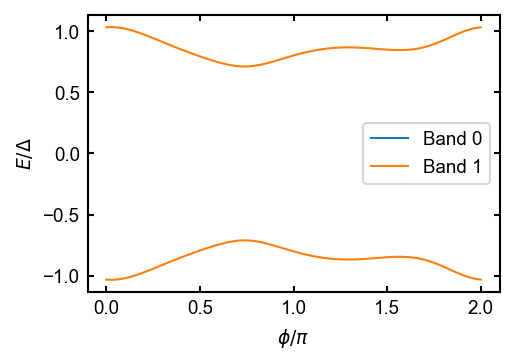

In [59]:
mu = 0.043
params_TI['B_x'] = 0/(W_y*H_z)
params_TI['mu_bulk'] = mu
params_TI['mu_lead1'] = mu
params_TI['mu_lead2'] = mu
params_TI['S_mag'] = 0.000
phases = np.linspace(0,2,101)
fig, ax, sols = plot_ABS_spectrum_calibrated(systf1, params_TI, phases, read_scattering_matrix = False, flux = "")
#ax.plot(phases, SNS(phases*np.pi, 0.1))

/Users/lulu/anaconda3/envs/kwant/lib/python3.9/site-packages/kwant/system.py:316: UserWarning: Hamiltonian breaks Time reversal, ignoring the symmetry in the computation.
  warnings.warn('Hamiltonian breaks ' + name +
/Users/lulu/anaconda3/envs/kwant/lib/python3.9/site-packages/kwant/system.py:316: UserWarning: Hamiltonian breaks Chiral, ignoring the symmetry in the computation.
  warnings.warn('Hamiltonian breaks ' + name +
/var/folders/t0/v_k6z8bs7t189fwv_9yfqbh00000gn/T/ipykernel_49637/1368297452.py:128: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigen_values)


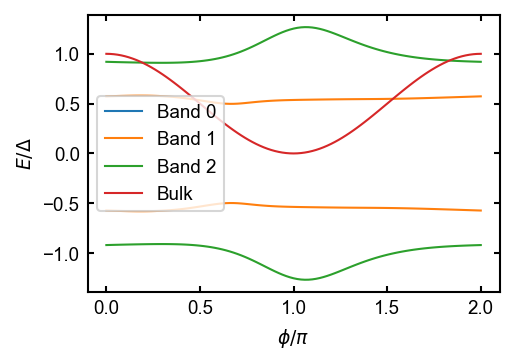

In [21]:
mu = 0.042
params_TI['B_x'] = 0.5/(W_y*H_z)
params_TI['mu_bulk'] = mu
params_TI['mu_lead1'] = mu
params_TI['mu_lead2'] = mu+0.003
params_TI['S_mag'] = 0.000
phases = np.linspace(0,2,101)
fig, ax, sols = plot_ABS_spectrum_calibrated(systf1, params_TI, phases, read_scattering_matrix = False, flux = "")
ax.plot(phases, 0.5*(np.cos(phases*np.pi)+1), 'C3', label='Bulk')
ax.legend()


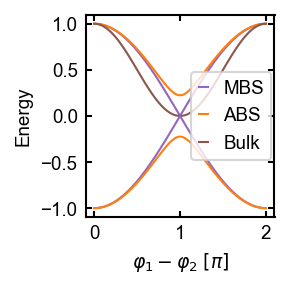

In [73]:
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.plot(phases, sols[0], 'C4', label='MBS')
ax.plot(phases, sols[1], 'C1', label='ABS')
ax.plot(phases, 0.5*(np.cos(phases*np.pi)+1), 'C5', label='Bulk')


ax.plot(phases, -1*sols[0], 'C4')
ax.plot(phases, -1*sols[1], 'C1')
#ax.plot(phases, 0.5*(np.cos(phases*np.pi)+1), 'C3', label='Bulk')
#ax.plot(1, 0, 'b*', ms=8)
ax.set_xlabel(r'$\varphi_{{1}}-\varphi_{{2}}$ $[\pi]$')
ax.set_ylabel(r'Energy')
ax.legend(handlelength=0.5, bbox_to_anchor=(0.51,0.5))
#ax.patch.set_color('blue')
ax.patch.set_alpha(0.5)

fig.savefig(path+'phase_dep.pdf')

## Tasks

In [ ]:
np.linspace(-0.032, 0.2, 9)

In [ ]:
mus = np.linspace(-0.05, 0.2, 51)
Smags = np.linspace(0, 0.05, 51)
gaps = []
params_TI['mu_lead1'] = 0.05
params_TI['mu_lead2'] = 0.05

for mu in mus:
    gap_mu = []
    params_TI['mu_bulk'] = 0.042+mu
    for s in Smags:
        params_TI['S_mag'] = s
        gap = find_gap(systf1, params_TI)
        #print(gap)
        gap_mu.append(gap)
    gaps.append(gap_mu)

In [ ]:
switches = [0.004, 0.042, 0.08, 0.12, 0.158, 0.196]

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
ax.set_xlabel('Correlated disorder strength (eV)')
ax.set_ylabel('Bulk potential mismatch (eV)')
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
ax.set_title(r'Gap opening (E/$\Delta$)')
im = ax.imshow(gaps,extent = (min(Smags), max(Smags), min(mus), max(mus)), 
                 origin='lower', aspect='auto')
fig.colorbar(im, cax=cax)

#for i in range(len(switches)):
#    ax.plot(Smags, switches[i] - Smags, label='# of modes={}'.format(2*i+1))
#ax.legend()

### Sweeping Flux Point

In [ ]:
flux = np.linspace(0.04, 0.06, 51)
SBs = []
params_TI['mu_lead1'] = 0.042
params_TI['mu_lead2'] = 0.042
params_TI['mu_bulk'] = 0.042
params_TI['S_mag'] = 0.033

for f in flux:
    params_TI['B_x'] = f/(W_y*H_z)
    
    SB = find_SB(systf1, params_TI)
        #print(gap)
    SBs.append(SB)

fig, ax = plt.subplots()
ax.plot(flux, SBs)
ax.set_xlabel(r'Threaded flux ($\Phi_0$)')
ax.set_ylabel(r'Symmetry breaking VS threaded flux')

In [ ]:
SBs

In [ ]:
fig, ax = plt.subplots()
ax.plot(flux, SBs, '*')
ax.set_xlabel(r'Threaded flux ($\Phi_0$)')
ax.set_ylabel(r'Symmetry breaking VS threaded flux')
ax.set_ylim(top=1e-1)

### Varying bulk chemical potentials

In [ ]:
params_TI['mu_bulk'] = 0.01
params_TI['mu_lead1'] = 0.01
params_TI['mu_lead2'] = 0.01

fig, ax = plt.subplots()
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$E/\Delta$')

mus = np.linspace(0.01, 0.05, 5)

i = 0
for mu in mus:
    params_TI['mu_bulk'] = mu

    phases = np.linspace(0,2,21)
    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta_calibrated(systf1, params_TI, phases=phase))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label=r'$\mu_bulk$={0:.2f}'.format(mu))
        ax.plot(phases, -1*sol, 'C'+str(i))
    i+=1
ax.legend()

### Varying uncorrelated disorder strength

In [ ]:
params_TI['mu_bulk'] = 0.01
params_TI['mu_lead1'] = 0.01
params_TI['mu_lead2'] = 0.01
params_TI['S_imp'] = get_S_imp_3D()

fig, ax = plt.subplots()
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$E/\Delta$')

S_mags = np.linspace(0.01, 0.05, 5)

i = 0
for s in S_mags:
    params_TI['S_mag'] = s

    phases = np.linspace(0,2,21)
    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta_calibrated(systf1, params_TI, phases=phase))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label="S_mag={0:.2f}".format(s))
        ax.plot(phases, -1*sol, 'C'+str(i))
    i+=1
ax.legend()

### Varying correlated disorder strength

In [ ]:
print('Correlation length is {}'.format(correlation_length))
print('Lattice size is {}'.format(a))

params_TI['mu_bulk'] = 0.01
params_TI['mu_lead1'] = 0.01
params_TI['mu_lead2'] = 0.01
params_TI['S_imp'] = get_S_imp_correlated()

fig, ax = plt.subplots()
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$E/\Delta$')

S_mags = np.linspace(0.01, 0.05, 5)

i = 0
for s in S_mags:
    params_TI['S_mag'] = s

    phases = np.linspace(0,2,21)
    sol_list = []
    for p in (phases)*np.pi:
        phase = [0, p]
        sol_list.append(energies_over_delta_calibrated(systf1, params_TI, phases=phase))
    
    sol_list = np.array(sol_list).T
    sol_list2 = sol_list[::2]
    for sol in sol_list2:
        ax.plot(phases, sol, 'C'+str(i), label='S_mag={0:.2f}'.format(s))
        ax.plot(phases, -1*sol, 'C'+str(i))
    i+=1
ax.legend()

# Appendix

## Band Structure

In [45]:
def plot_bands(syst, momenta, return_bands=False, plot_bands=True, params=None, levels=0):
    bands = kwant.physics.Bands(syst.leads[0], params=params)
    energies = np.array([bands(k) for k in momenta])
    if levels!=0:
        mid = len(energies[0])//2
        a=energies[:,mid-levels:mid]
        b=energies[:,mid:mid+levels]
        energies = np.concatenate((a,b),axis=1)
        i = 1
    if plot_bands:
        fig, ax = plt.subplots()
        ax.set_xlabel('k')
        ax.set_ylabel('Energy')
        ax.plot(momenta, energies)
        #ax.plot(momenta, np.full(len(momenta), 0.005), 'b--')
        #ax.plot(momenta, np.full(len(momenta), 0.015), 'r--')
        #ax.legend()
        plt.show()
    if return_bands:
        return energies

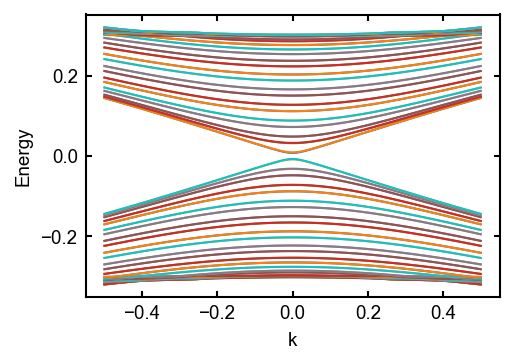

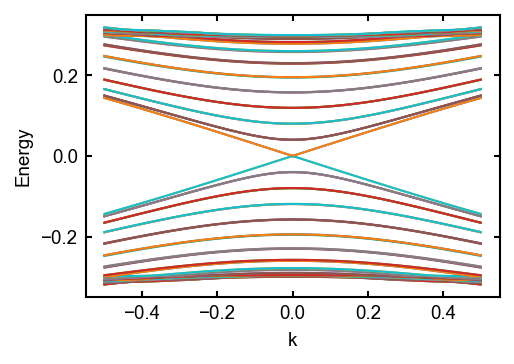

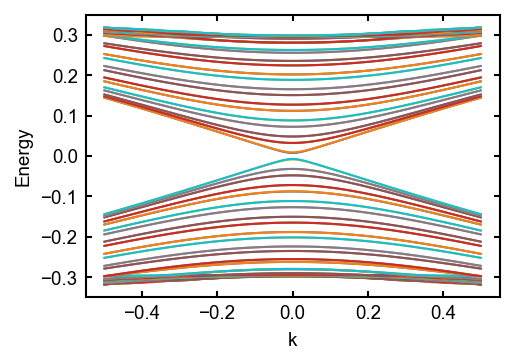

In [15]:
def plot_bands(syst, momenta, return_bands=False, plot_bands=True, params=None, levels=0):
    bands = kwant.physics.Bands(syst.leads[0], params=params)
    energies = np.array([bands(k) for k in momenta])
    if levels!=0:
        mid = len(energies[0])//2
        a=energies[:,mid-levels:mid]
        b=energies[:,mid:mid+levels]
        energies = np.concatenate((a,b),axis=1)
        i = 1
    if plot_bands:
        fig, ax = plt.subplots()
        ax.set_xlabel('k')
        ax.set_ylabel('Energy')
        ax.plot(momenta, energies)
        #ax.plot(momenta, np.full(len(momenta), 0.005), 'b--')
        #ax.plot(momenta, np.full(len(momenta), 0.015), 'r--')
        #ax.legend()
        plt.show()
    if return_bands:
        return energies
    

params_TI['mu_bulk'] = 0.0
params_TI['mu_lead1'] = 0.0
params_TI['mu_lead2'] = 0.0
params_TI['B_x'] = 0.3/(W_y*H_z)
momenta = np.linspace(-.5, .5, 101)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=50, params=params_TI)

params_TI['mu_bulk'] = 0.0
params_TI['mu_lead1'] = 0.0
params_TI['mu_lead2'] = 0.0
params_TI['B_x'] = 0.5/(W_y*H_z)
momenta = np.linspace(-.5, .5, 101)
r2 = plot_bands(systf1, momenta, return_bands=True, levels=50, params=params_TI)

params_TI['mu_bulk'] = 0.0
params_TI['mu_lead1'] = 0.0
params_TI['mu_lead2'] = 0.0
params_TI['B_x'] = 0.7/(W_y*H_z)
momenta = np.linspace(-.5, .5, 101)
r3 = plot_bands(systf1, momenta, return_bands=True, levels=50, params=params_TI)

#print(r1)

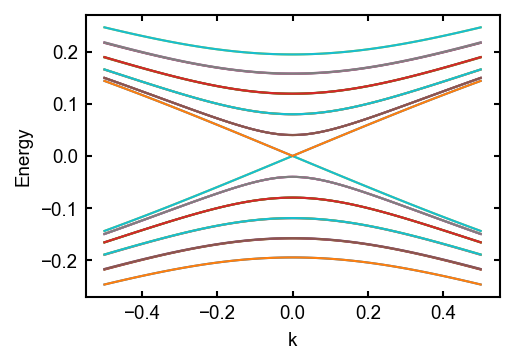

IndexError: index 50 is out of bounds for axis 1 with size 40

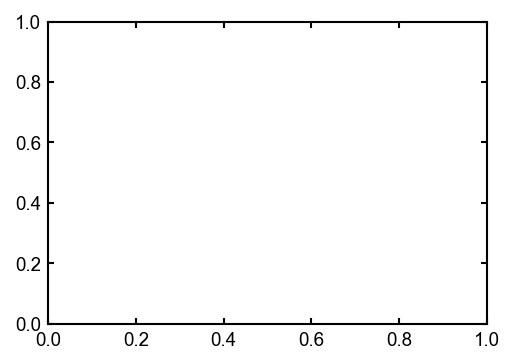

In [46]:
params_TI['mu_bulk'] = 0.0
params_TI['mu_lead1'] = 0.0
params_TI['mu_lead2'] = 0.0
params_TI['B_x'] = 0.5/(W_y*H_z)
momenta = np.linspace(-.5, .5, 101)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=20, params=params_TI)
fig, ax = plt.subplots()
ax.plot(momenta, r1[:,len(r1)//2], 'C1')
ax.plot(momenta, r1[:,len(r1)//2-1], 'C1')
ax.plot(momenta, r1[:,len(r1)//2+8], 'C1')
ax.plot(momenta, r1[:,len(r1)//2-9], 'C1')
ax.plot(momenta, r1[:,len(r1)//2+16], 'C1')
ax.plot(momenta, r1[:,len(r1)//2-17], 'C1')
ax.plot(momenta, r1[:,len(r1)//2+24], 'C1')
ax.plot(momenta, r1[:,len(r1)//2-25], 'C1')
for i in range(10):
    ax.plot(momenta, r1[:,i], 'C5')
    ax.plot(momenta, r1[:,-i], 'C5')
ax.set_xlabel('k')
ax.set_ylabel('Energy')

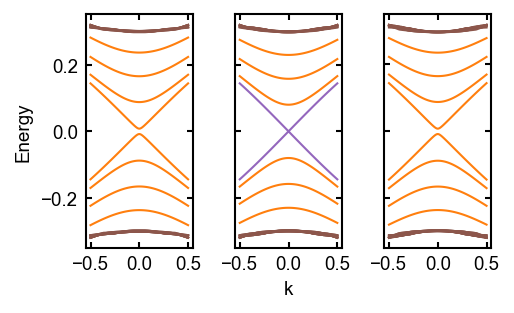

In [51]:
fig, axes = plt.subplots(1,3, sharex=True, figsize=(7, 5))

axes[0].plot(momenta, r1[:,len(r1)//2], 'C1')
axes[0].plot(momenta, r1[:,len(r1)//2-1], 'C1')
axes[0].plot(momenta, r1[:,len(r1)//2+8], 'C1')
axes[0].plot(momenta, r1[:,len(r1)//2-9], 'C1')
axes[0].plot(momenta, r1[:,len(r1)//2+16], 'C1')
axes[0].plot(momenta, r1[:,len(r1)//2-17], 'C1')
axes[0].plot(momenta, r1[:,len(r1)//2+24], 'C1')
axes[0].plot(momenta, r1[:,len(r1)//2-25], 'C1')
for i in range(10):
    axes[0].plot(momenta, r1[:,i], 'C5')
    axes[0].plot(momenta, r1[:,-i], 'C5')
#axes[0].set_xlabel('k')
axes[0].set_ylabel('Energy')
#axes[0].set_facecolor('silver')
#axes[0].patch.set_alpha(0.5)

axes[1].plot(momenta, r2[:,len(r2)//2], 'C4')
axes[1].plot(momenta, r2[:,len(r2)//2-1], 'C4')
axes[1].plot(momenta, r2[:,len(r2)//2+6], 'C1')
axes[1].plot(momenta, r2[:,len(r2)//2-7], 'C1')
axes[1].plot(momenta, r2[:,len(r2)//2+14], 'C1')
axes[1].plot(momenta, r2[:,len(r2)//2-15], 'C1')
axes[1].plot(momenta, r2[:,len(r2)//2+22], 'C1')
axes[1].plot(momenta, r2[:,len(r2)//2-23], 'C1')
for i in range(10):
    axes[1].plot(momenta, r2[:,i], 'C5')
    axes[1].plot(momenta, r2[:,-i], 'C5')
#axes[1].plot(0, 0, 'b*', ms=8)
axes[1].set_yticklabels([])
axes[1].patch.set_alpha(0.5)
#axes[1].set_facecolor('blue')

#axes[1].set_xlabel('k')
#axes[1].set_ylabel('Energy')

axes[2].plot(momenta, r3[:,len(r3)//2], 'C1')
axes[2].plot(momenta, r3[:,len(r3)//2-1], 'C1')
axes[2].plot(momenta, r3[:,len(r3)//2+8], 'C1')
axes[2].plot(momenta, r3[:,len(r3)//2-9], 'C1')
axes[2].plot(momenta, r3[:,len(r3)//2+16], 'C1')
axes[2].plot(momenta, r3[:,len(r3)//2-17], 'C1')
axes[2].plot(momenta, r3[:,len(r3)//2+24], 'C1')
axes[2].plot(momenta, r3[:,len(r3)//2-25], 'C1')
for i in range(10):
    axes[2].plot(momenta, r3[:,i], 'C5')
    axes[2].plot(momenta, r3[:,-i], 'C5')
#axes[2].set_xlabel('k')
axes[2].set_yticklabels([])
#axes[2].set_facecolor('black')
axes[2].patch.set_alpha(0.5)

fig.text(0.56, 0.0, 'k', ha='center')
path = '/Users/lulu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD thesis/Majorana Simulation/'
fig.savefig(path + 'band_structures.pdf')

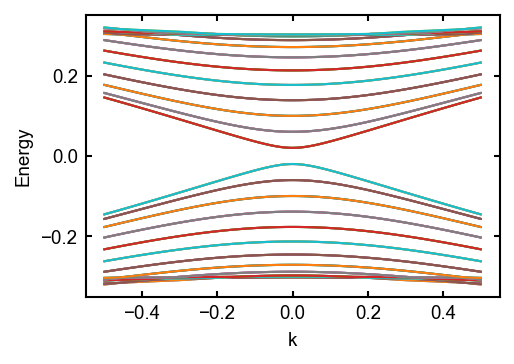

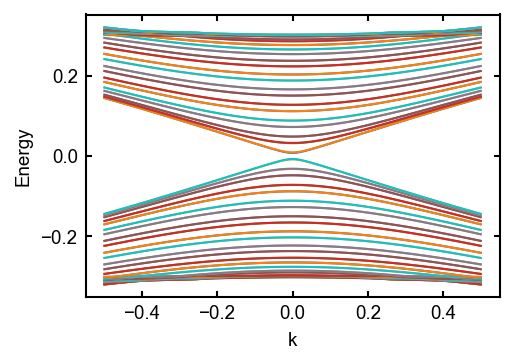

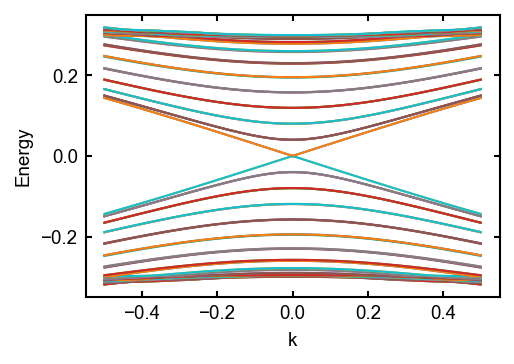

In [16]:
def plot_bands(syst, momenta, return_bands=False, plot_bands=True, params=None, levels=0):
    bands = kwant.physics.Bands(syst.leads[0], params=params)
    energies = np.array([bands(k) for k in momenta])
    if levels!=0:
        mid = len(energies[0])//2
        a=energies[:,mid-levels:mid]
        b=energies[:,mid:mid+levels]
        energies = np.concatenate((a,b),axis=1)
        i = 1
    if plot_bands:
        fig, ax = plt.subplots()
        ax.set_xlabel('k')
        ax.set_ylabel('Energy')
        ax.plot(momenta, energies)
        #ax.plot(momenta, np.full(len(momenta), 0.005), 'b--')
        #ax.plot(momenta, np.full(len(momenta), 0.015), 'r--')
        #ax.legend()
        plt.show()
    if return_bands:
        return energies
    

params_TI['mu_bulk'] = 0.0
params_TI['mu_lead1'] = 0.0
params_TI['mu_lead2'] = 0.0
params_TI['B_x'] = 0.0/(W_y*H_z)
momenta = np.linspace(-.5, .5, 101)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=50, params=params_TI)

params_TI['mu_bulk'] = 0.0
params_TI['mu_lead1'] = 0.0
params_TI['mu_lead2'] = 0.0
params_TI['B_x'] = 0.3/(W_y*H_z)
momenta = np.linspace(-.5, .5, 101)
r2 = plot_bands(systf1, momenta, return_bands=True, levels=50, params=params_TI)

params_TI['mu_bulk'] = 0.0
params_TI['mu_lead1'] = 0.0
params_TI['mu_lead2'] = 0.0
params_TI['B_x'] = 0.5/(W_y*H_z)
momenta = np.linspace(-.5, .5, 101)
r3 = plot_bands(systf1, momenta, return_bands=True, levels=50, params=params_TI)

#print(r1)

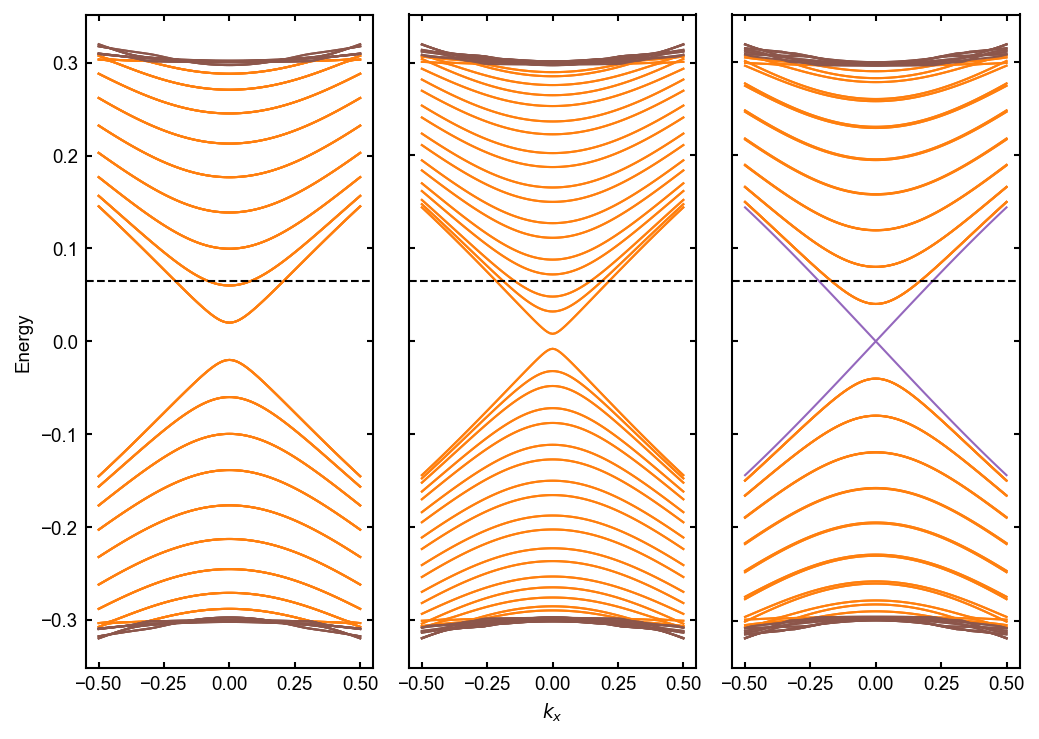

In [26]:
fig, axes = plt.subplots(1,3, sharex=True, figsize=(7, 5))

surface_no = 36
for i in range(surface_no):

    axes[0].plot(momenta, r1[:,len(r1)//2-i-1], 'C1')
    axes[0].plot(momenta, r1[:,len(r1)//2+i], 'C1')
for i in range(50-surface_no):
    axes[0].plot(momenta, r1[:,i], 'C5')
    axes[0].plot(momenta, r1[:,-i], 'C5')
#axes[0].set_xlabel('k')
axes[0].set_ylabel('Energy')
axes[0].axhline(y=0.065, c='k', ls='--')
#axes[0].set_facecolor('silver')
#axes[0].patch.set_alpha(0.5)

for i in range(surface_no):

    axes[1].plot(momenta, r2[:,len(r1)//2-i-1], 'C1')
    axes[1].plot(momenta, r2[:,len(r1)//2+i], 'C1')
for i in range(50-surface_no):
    axes[1].plot(momenta, r2[:,i], 'C5')
    axes[1].plot(momenta, r2[:,-i], 'C5')
#axes[1].plot(0, 0, 'b*', ms=8)
axes[1].set_yticklabels([])
axes[1].patch.set_alpha(0.5)
axes[1].axhline(y=0.065, c='k', ls='--')
#axes[1].set_facecolor('blue')

#axes[1].set_xlabel('k')
#axes[1].set_ylabel('Energy')

axes[2].plot(momenta, r3[:,len(r2)//2], 'C4')
axes[2].plot(momenta, r3[:,len(r2)//2-1], 'C4')
for i in range(2, surface_no):

    axes[2].plot(momenta, r3[:,len(r1)//2-i-1], 'C1')
    axes[2].plot(momenta, r3[:,len(r1)//2+i], 'C1')
for i in range(50-surface_no):
    axes[2].plot(momenta, r3[:,i], 'C5')
    axes[2].plot(momenta, r3[:,-i], 'C5')
#axes[2].set_xlabel('k')
axes[2].set_yticklabels([])
#axes[2].set_facecolor('black')
axes[2].patch.set_alpha(0.5)
axes[2].axhline(y=0.065, c='k', ls='--')

#fig.text(0.56, 0.0, r'$k_\parallel$', ha='center')
axes[1].set_xlabel(r'$k_x$')
path = '/Users/lulu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD thesis/Majorana Simulation/'
fig.savefig(path + 'band_structures_thesis.pdf')

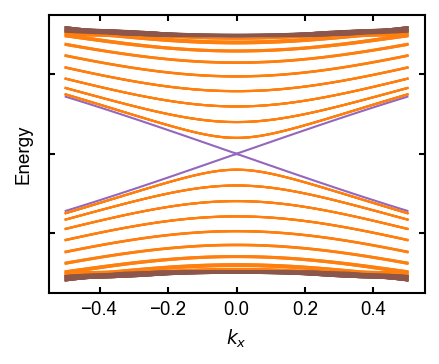

In [21]:
fig, ax = plt.subplots(figsize=(3,2.5))

surface_no = 36


ax.plot(momenta, r3[:,len(r2)//2], 'C4')
ax.plot(momenta, r3[:,len(r2)//2-1], 'C4')
for i in range(2, surface_no):

    ax.plot(momenta, r3[:,len(r1)//2-i-1], 'C1')
    ax.plot(momenta, r3[:,len(r1)//2+i], 'C1')
for i in range(50-surface_no):
    ax.plot(momenta, r3[:,i], 'C5')
    ax.plot(momenta, r3[:,-i], 'C5')
#axes[2].set_xlabel('k')
ax.set_yticklabels([])
#axes[2].set_facecolor('black')
ax.patch.set_alpha(0.5)
#ax.axhline(y=0.065, c='k', ls='--')

#fig.text(0.56, 0.0, r'$k_\parallel$', ha='center')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel('Energy')
path = '/Users/lulu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD thesis/Majorana Simulation/'
#fig.savefig(path + 'band_structures_thesis.pdf')

Text(0, 0.5, 'Energy')

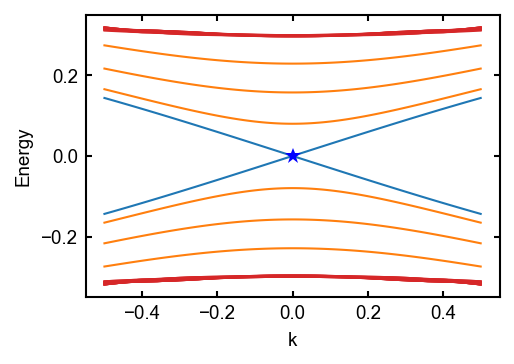

In [61]:
fig, ax = plt.subplots()
ax.plot(momenta, r1[:,len(r1)//2], 'C0')
ax.plot(momenta, r1[:,len(r1)//2-1], 'C0')
ax.plot(momenta, r1[:,len(r1)//2+6], 'C1')
ax.plot(momenta, r1[:,len(r1)//2-7], 'C1')
ax.plot(momenta, r1[:,len(r1)//2+14], 'C1')
ax.plot(momenta, r1[:,len(r1)//2-15], 'C1')
ax.plot(momenta, r1[:,len(r1)//2+22], 'C1')
ax.plot(momenta, r1[:,len(r1)//2-23], 'C1')
for i in range(10):
    ax.plot(momenta, r1[:,i], 'C3')
    ax.plot(momenta, r1[:,-i], 'C3')
ax.plot(0, 0, 'b*', ms=8)
ax.set_xlabel('k')
ax.set_ylabel('Energy')

Text(0, 0.5, 'Energy')

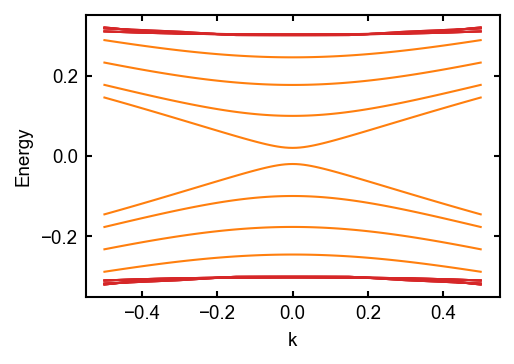

In [64]:
fig, ax = plt.subplots()
ax.plot(momenta, r2[:,len(r1)//2], 'C1')
ax.plot(momenta, r2[:,len(r1)//2-1], 'C1')
ax.plot(momenta, r2[:,len(r1)//2+8], 'C1')
ax.plot(momenta, r2[:,len(r1)//2-9], 'C1')
ax.plot(momenta, r2[:,len(r1)//2+16], 'C1')
ax.plot(momenta, r2[:,len(r1)//2-17], 'C1')
ax.plot(momenta, r2[:,len(r1)//2+24], 'C1')
ax.plot(momenta, r2[:,len(r1)//2-25], 'C1')
for i in range(10):
    ax.plot(momenta, r2[:,i], 'C3')
    ax.plot(momenta, r2[:,-i], 'C3')
ax.set_xlabel('k')
ax.set_ylabel('Energy')

In [26]:
params_TI

{'A_perp': 3.0,
 'A_z': 3.0,
 'M_0': 0.3,
 'M_perp': 15.0,
 'M_z': 15.0,
 'C_0': 0.0,
 'C_perp': 0.0,
 'C_z': 0.0,
 'm_z': 0.0,
 'mu_bulk': 0.0,
 'mu_lead1': 0.0,
 'mu_lead2': 0.0,
 'S_imp': <function __main__.get_S_imp_correlated.<locals>.S_imp(site)>,
 'S_mag': 0.0,
 'B_x': 5e-05,
 'B_y': 0.0,
 'B_z': 0.0,
 'phi_0': 1.0,
 'exp': <ufunc 'exp'>,
 'a': 20,
 're': <function __main__.<lambda>(x)>,
 'im': <function __main__.<lambda>(x)>,
 'Deltaf_L': <function __main__.<lambda>(y, z)>,
 'Deltaf_R': <function __main__.<lambda>(y, z)>,
 'H_z': 100}

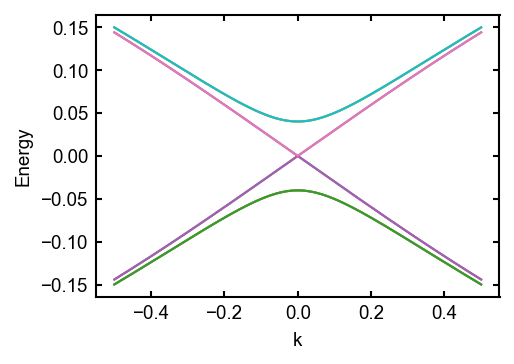

-0.14956474130131758


In [24]:
Delta = 0.0
params_TI['mu_bulk'] = 0.0
params_TI['mu_lead1'] = 0.0
params_TI['mu_lead2'] = 0.0
momenta = np.linspace(-.5, .5, 201)
params_TI['B_x'] = 0.500643/(W_y*H_z)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=5, params=params_TI)
#print(min(r1[:,1]))
    #min_gap.append(min(r1[:,10]))
    

#print(r1)

In [157]:
print(min(r1[:,5]))

2.699431674396155e-06


In [136]:
min(r1[:,10])

4.42281910170276e-06

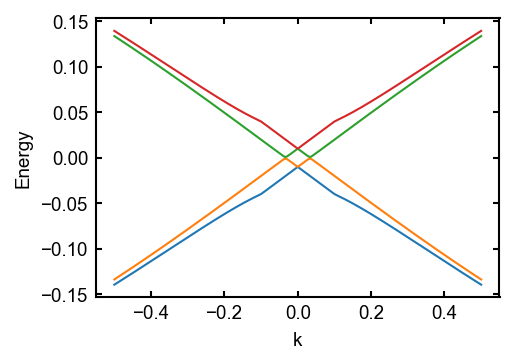

(-0.01, 0.01)

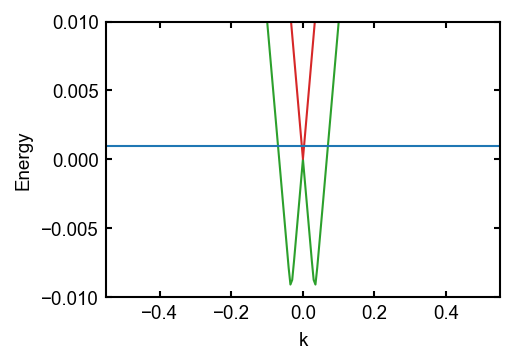

In [160]:
Delta = 0.001
params_TI['mu_bulk'] = 0.01
params_TI['mu_lead1'] = 0.01
params_TI['mu_lead2'] = 0.01
params_TI['B_x'] = 0.500643/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.5, .5, 201)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=2, params=params_TI)
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('Energy')
ax.plot(momenta, r1-0.01)
ax.axhline(y=0.00)
ax.set_ylim(ymax=0.01, ymin=-0.01)

#print(r1)

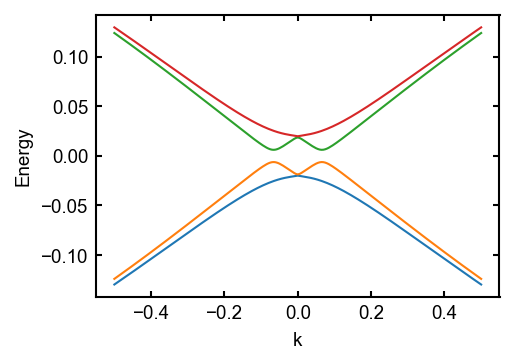

(-0.01, 0.01)

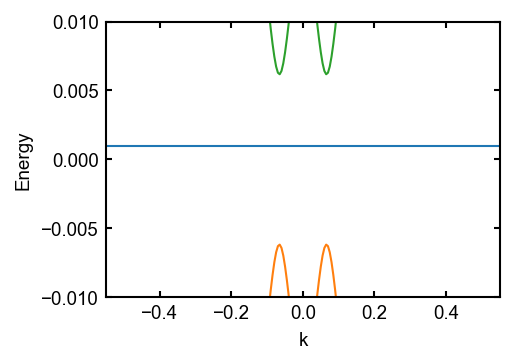

In [117]:
Delta = 0.008
params_TI['mu_bulk'] = 0.02
params_TI['mu_lead1'] = 0.02
params_TI['mu_lead2'] = 0.02
params_TI['B_x'] = 0.5/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.5, .5, 201)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=2, params=params_TI)
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('Energy')
ax.plot(momenta, r1)
ax.axhline(y=0.001)
ax.set_ylim(ymax=0.01, ymin=-0.01)

#print(r1)

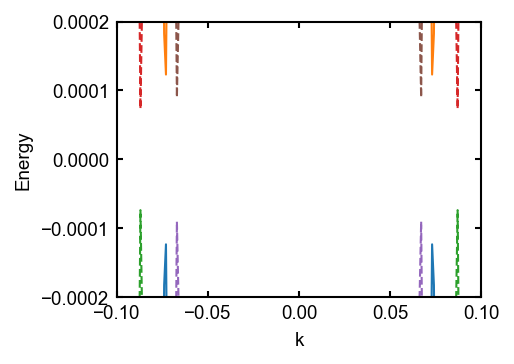

In [101]:
Delta = 0.0001
params_TI['mu_bulk'] = 0.022
params_TI['mu_lead1'] = 0.022
params_TI['mu_lead2'] = 0.022
params_TI['B_x'] = 0.5/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.1, .1, 201)
#r1 = plot_bands(systf1, momenta, return_bands=True, levels=1, params=params_TI)


Delta = 0.0001
params_TI['mu_bulk'] = 0.026
params_TI['mu_lead1'] = 0.026
params_TI['mu_lead2'] = 0.026
params_TI['B_x'] = 0.5/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.1, .1, 201)
#r2 = plot_bands(systf1, momenta, return_bands=True, levels=1, params=params_TI)

Delta = 0.0001
params_TI['mu_bulk'] = 0.02
params_TI['mu_lead1'] = 0.02
params_TI['mu_lead2'] = 0.02
params_TI['B_x'] = 0.5/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.1, .1, 201)
#r3 = plot_bands(systf1, momenta, return_bands=True, levels=1, params=params_TI)


Delta = 0.0001
params_TI['mu_bulk'] = 0.028
params_TI['mu_lead1'] = 0.028
params_TI['mu_lead2'] = 0.028
params_TI['B_x'] = 0.5/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.1, .1, 201)
#r4 = plot_bands(systf1, momenta, return_bands=True, levels=1, params=params_TI)
#fig, ax = plt.subplots()
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('Energy')
ax.plot(momenta, r1[:,0])
ax.plot(momenta, r1[:,1])
ax.plot(momenta, r2[:,0], '--')
ax.plot(momenta, r2[:,1], '--')
ax.plot(momenta, r3, '--')

ax.set_ylim(ymax=0.0002, ymin=-0.0002)
ax.set_xlim(xmax=0.1, xmin=-0.1)
plt.show()
#print(r1)

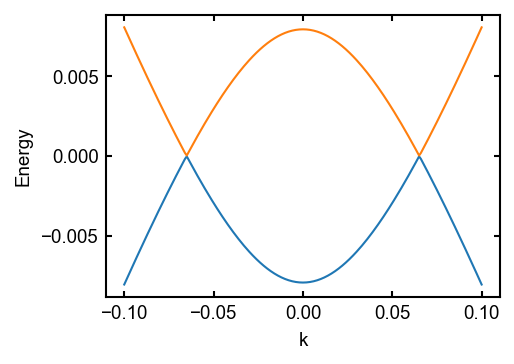

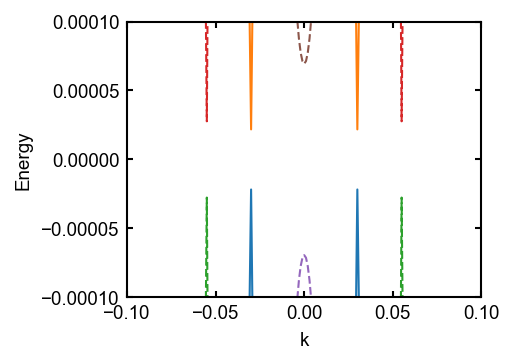

In [99]:
Delta = 0.0001
params_TI['mu_bulk'] = 0.022
params_TI['mu_lead1'] = 0.022
params_TI['mu_lead2'] = 0.022
params_TI['B_x'] = 0.0/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.1, .1, 201)
#r1 = plot_bands(systf1, momenta, return_bands=True, levels=1, params=params_TI)


Delta = 0.0001
params_TI['mu_bulk'] = 0.026
params_TI['mu_lead1'] = 0.026
params_TI['mu_lead2'] = 0.026
params_TI['B_x'] = 0.0/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.1, .1, 201)
#r2 = plot_bands(systf1, momenta, return_bands=True, levels=1, params=params_TI)

Delta = 0.0001
params_TI['mu_bulk'] = 0.02
params_TI['mu_lead1'] = 0.02
params_TI['mu_lead2'] = 0.02
params_TI['B_x'] = 0.0/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.1, .1, 201)
#r3 = plot_bands(systf1, momenta, return_bands=True, levels=1, params=params_TI)


Delta = 0.0001
params_TI['mu_bulk'] = 0.028
params_TI['mu_lead1'] = 0.028
params_TI['mu_lead2'] = 0.028
params_TI['B_x'] = 0.0/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.1, .1, 201)
r4 = plot_bands(systf1, momenta, return_bands=True, levels=1, params=params_TI)
#fig, ax = plt.subplots()
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('Energy')
ax.plot(momenta, r1[:,0])
ax.plot(momenta, r1[:,1])
ax.plot(momenta, r2[:,0], '--')
ax.plot(momenta, r2[:,1], '--')
ax.plot(momenta, r3, '--')

ax.set_ylim(ymax=0.0001, ymin=-0.0001)
ax.set_xlim(xmax=0.1, xmin=-0.1)
plt.show()
#print(r1)

(-0.1, 0.1)

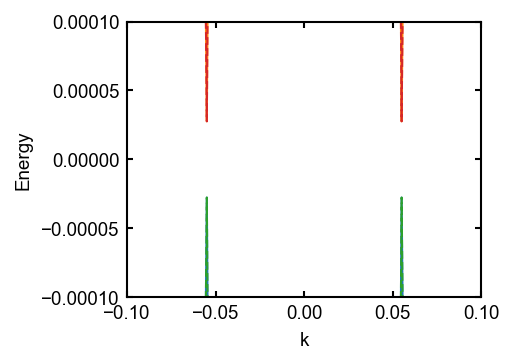

In [96]:
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('Energy')
ax.plot(momenta, r1[:,0])
ax.plot(momenta, r1[:,1])
ax.plot(momenta, r2[:,0], '--')
ax.plot(momenta, r2[:,1], '--')

ax.set_ylim(ymax=0.0001, ymin=-0.0001)
ax.set_xlim(xmax=0.1, xmin=-0.1)

(-0.1, 0.1)

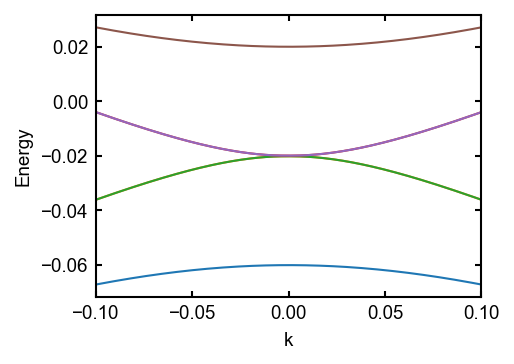

In [163]:
Delta = 0.0001
params_TI['mu_bulk'] = 0.02
params_TI['mu_lead1'] = 0.02
params_TI['mu_lead2'] = 0.02
params_TI['B_x'] = 0.0/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.1, .1, 201)
#r1 = plot_bands(systf1, momenta, return_bands=True, levels=3, params=params_TI)
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('Energy')
ax.plot(momenta, r1-0.02)
#ax.set_ylim(ymax=0.0005, ymin=-0.0005)
ax.set_xlim(xmax=0.1, xmin=-0.1)
#print(r1)

(-0.1, 0.1)

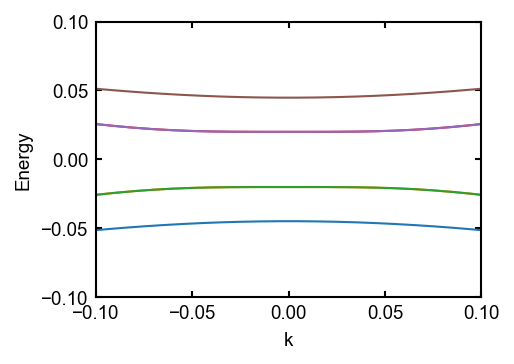

In [81]:
Delta = 0.02
params_TI['mu_bulk'] = 0.02
params_TI['mu_lead1'] = 0.02
params_TI['mu_lead2'] = 0.02
params_TI['B_x'] = 0.0/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.5, .5, 201)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=3, params=params_TI)
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('Energy')
ax.plot(momenta, r1)
ax.set_ylim(ymax=0.1, ymin=-0.1)
ax.set_xlim(xmax=0.1, xmin=-0.1)

#print(r1)

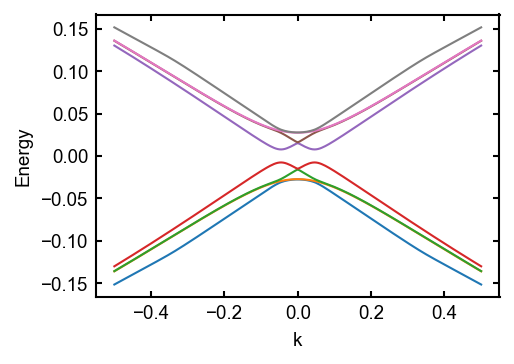

(-0.02, 0.02)

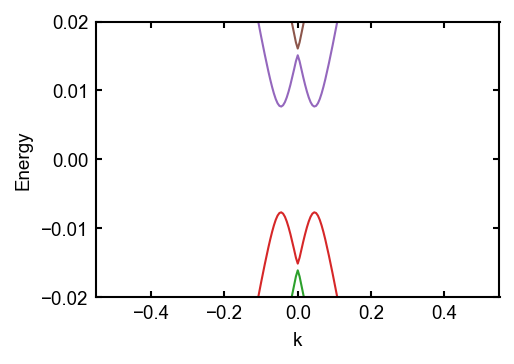

In [46]:
Delta = 0.01
params_TI['mu_bulk'] = 0.014
params_TI['mu_lead1'] = 0.014
params_TI['mu_lead2'] = 0.014
params_TI['B_x'] = 0.0/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.5, .5, 201)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=4, params=params_TI)
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('Energy')
ax.plot(momenta, r1)
ax.set_ylim(ymax=0.02, ymin=-0.02)

#print(r1)

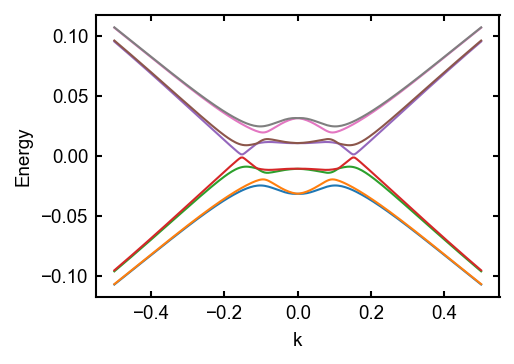

(-0.02, 0.02)

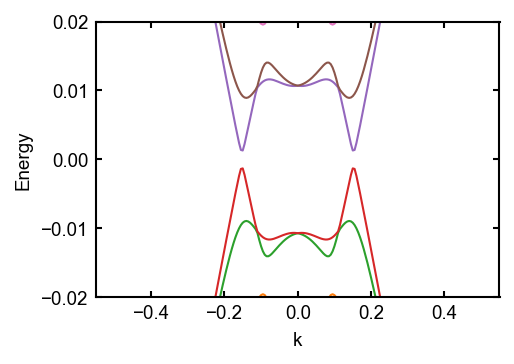

In [35]:
Delta = 0.02
params_TI['mu_bulk'] = 0.05
params_TI['mu_lead1'] = 0.05
params_TI['mu_lead2'] = 0.05
params_TI['B_x'] = 0.0/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.5, .5, 201)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=4, params=params_TI)
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('Energy')
ax.plot(momenta, r1)
ax.set_ylim(ymax=0.02, ymin=-0.02)

#print(r1)

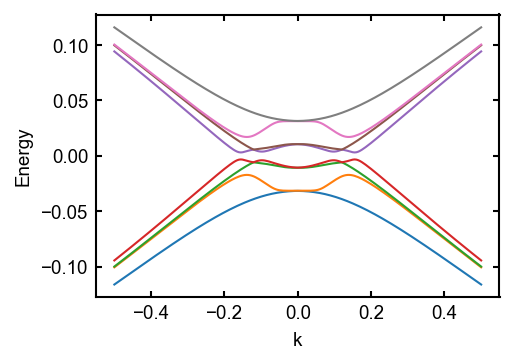

(-0.02, 0.02)

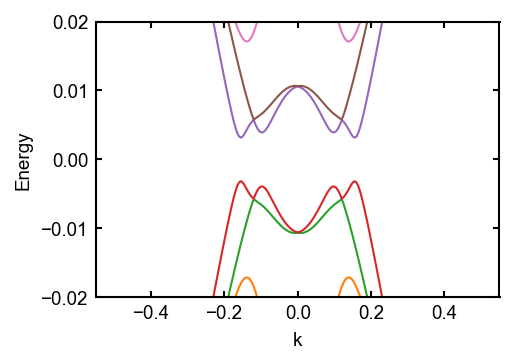

In [36]:
Delta = 0.02
params_TI['mu_bulk'] = 0.05
params_TI['mu_lead1'] = 0.05
params_TI['mu_lead2'] = 0.05
params_TI['B_x'] = 0.5/(W_y*H_z)
params_TI['B_y'] = 0.0/(L_x*H_z)
momenta = np.linspace(-.5, .5, 201)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=4, params=params_TI)
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('Energy')
ax.plot(momenta, r1)
ax.set_ylim(ymax=0.02, ymin=-0.02)

#print(r1)

## Visualise the disorder profile

In [ ]:
from matplotlib import cm

S_mag = 0.01

z=S_mag * disorder_fil.mean(axis =(2))*1000

x=np.linspace(0,L_x//a,L_x//a+1)
y=np.linspace(0,10,11) # Why is it ten?
X, Y = np.meshgrid(x, y)

fig, axs=plt.subplots(figsize=(10,5))

cs=axs.contourf(X,Y,z,cmap=cm.PuBu_r)
# plot = plt.contourf(X,Y,filter_kernel)
# plt.axis('scaled')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')


axs.set_aspect(10)

cbar=fig.colorbar(cs, orientation='horizontal', label='Chemical Potential Disorder (meV)')
plt.show()

In [ ]:
xval=np.linspace(0,L_x//a,L_x//a+1)
xvals=xval.astype(int)
dis=[]
dis2=[]
S_mag = 0.02
for x in xvals:
      dis.append(S_mag*disorder[0,x,0])

for x in xvals:
      dis2.append(S_mag*disorder_fil[0,x,0])
        
plt.plot(xvals,dis,label='Unfiltered')
plt.plot(xvals,dis2,linewidth=7,label='filtered')
plt.xlabel('x-coordinate (nm)')
plt.ylabel('Disorder (meV)')
plt.legend()
plt.show()

In [ ]:
disorder[0,1,0]